In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from tqdm import tqdm

import sys
import MEDR
random_seed = 2025
MEDR.fix_seed(random_seed)

### Step1， processing multi-slice data, involves constructing spatiotemporal graphs and feature graphs. The core task here is to build spatiotemporal graphs, which capture the relationships and interactions among different data points in both space and time, as well as feature graphs, which represent the attributes or features of the data points themselves, facilitating deeper analysis or processing.

In [2]:

data_root = Path('/share/home/bgi_clicx/SEDR/Inf_final_all_anno')


sample_files = os.listdir(data_root)
sample_list = [file for file in sample_files if file.endswith('.h5ad')]


adata = None
spatial_graph = None
feat_graph = None


results={}

for i, sample_name in enumerate(tqdm(sample_list)):
    adata_tmp = sc.read_h5ad(data_root / sample_name)
    adata_tmp.var_names_make_unique()

    # sample_id = sample_name.split('.')
    
    sample_id = sample_name.split('.')[0]
    print(sample_id)
    # batch_id = sample_id.split('_')[1]
    adata_tmp.obs['batch_name'] = sample_id



    adata_tmp.obsm['spatial'] = adata_tmp.obs[['x', 'y']].values

    spatial_graph_tmp = MEDR.graph_construction(adata_tmp, n=12, mode='KNN')

    feat_graph_tmp = MEDR.graph_construction(adata_tmp, celltype_use='cell_type2', mode='Celltype')

    if adata is None:
        adata = adata_tmp
        spatial_graph = spatial_graph_tmp
        feat_graph = feat_graph_tmp
        adata.obs['proj_name'] = sample_id
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = sample_id

        adata = adata.concatenate(adata_tmp)
        spatial_graph = MEDR.combine_graph_dict(spatial_graph, spatial_graph_tmp)
        feat_graph = MEDR.combine_graph_dict(feat_graph, feat_graph_tmp)



  0%|          | 0/8 [00:00<?, ?it/s]

sample7_SPM


 12%|█▎        | 1/8 [00:00<00:03,  2.13it/s]

sample4_SBM


 25%|██▌       | 2/8 [00:00<00:02,  2.62it/s]

sample8_SPM


 38%|███▊      | 3/8 [00:01<00:01,  2.74it/s]

sample5_SBM


 50%|█████     | 4/8 [00:01<00:01,  2.41it/s]

sample3_SBM


 62%|██████▎   | 5/8 [00:02<00:01,  1.72it/s]

sample1_PBM


 75%|███████▌  | 6/8 [00:03<00:01,  1.77it/s]

sample2_PBM


 88%|████████▊ | 7/8 [00:03<00:00,  1.82it/s]

sample6_SPM


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


#### spatial transcriptomics data visualization


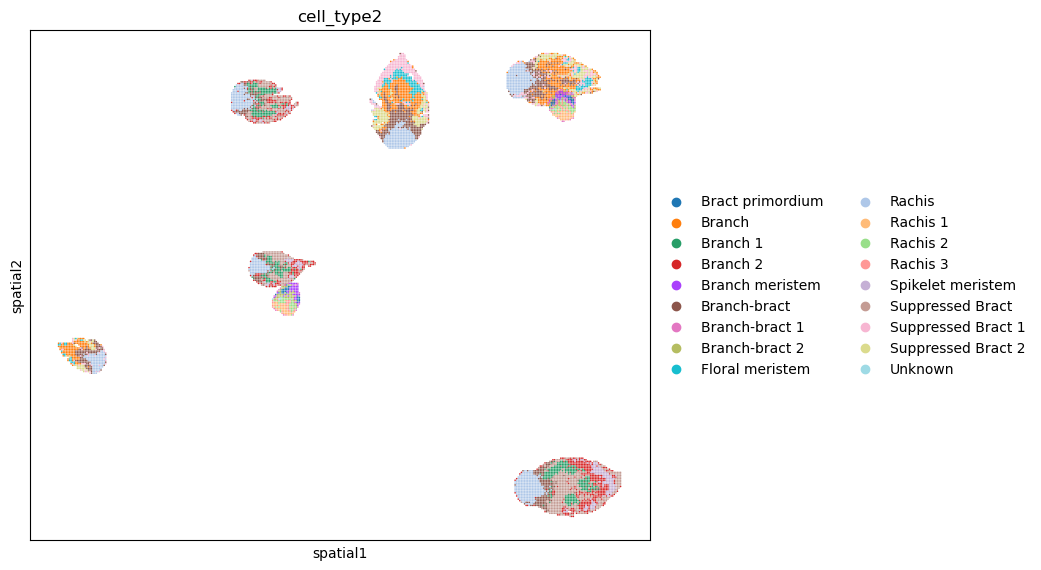

In [3]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.spatial(adata, color='cell_type2', spot_size=50, show=False, ax=ax, img_key="hires")
ax.invert_yaxis()

### Step2, use the MEDR method to learn spatial latent features from SRT data, with cell embeddings obtained from RICE scGPT serving as the input to MEDR.
### Of course, MEDR also supports using PCA embeddings, as shown in the following example.

In [4]:
# using RICE scgpt embeddings

# model = MEDR.Trainer(adata.obsm['X_scGPT'], spatial_graph, feat_graph, device = 'cuda:0')
# model.train()
# medr_feat, _ = model.process()
# adata.obsm['MEDR'] = medr_feat


# using PCA embeddings

adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=3000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.log1p(adata)
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

model = MEDR.Trainer(adata.obsm['X_pca'], spatial_graph, feat_graph, device = 'cuda:0')
model.train()
medr_feat, _ = model.process()
adata.obsm['MEDR'] = medr_feat

Using device: cuda:0


100%|██████████| 200/200 [00:08<00:00, 24.63it/s]


### Step3, perform batch effect correction using Harmony.

In [5]:
import harmonypy as hm

meta_data = adata.obs[['batch_name']]

data_mat = adata.obsm['MEDR']
vars_use = ['batch_name']
ho = hm.run_harmony(data_mat, meta_data, vars_use)

res = pd.DataFrame(ho.Z_corr).T
res_df = pd.DataFrame(data=res.values, columns=['X{}'.format(i+1) for i in range(res.shape[1])], index=adata.obs.index)
adata.obsm[f'MEDR.Harmony'] = res_df


results = {
    'MEDR': adata.obsm['MEDR.Harmony'],
    'cell_type': adata.obs['cell_type2'].values,
}

results_path = '/share/home/bgi_clicx/cell_code/ST_Inflorescence_merge.pickle'
with open(results_path, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

2025-12-04 19:58:54,654 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-12-04 19:58:56,444 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-04 19:58:56,461 - harmonypy - INFO - Iteration 1 of 10
2025-12-04 19:58:57,425 - harmonypy - INFO - Iteration 2 of 10
2025-12-04 19:58:58,385 - harmonypy - INFO - Iteration 3 of 10
2025-12-04 19:59:00,850 - harmonypy - INFO - Iteration 4 of 10
2025-12-04 19:59:01,711 - harmonypy - INFO - Iteration 5 of 10
2025-12-04 19:59:02,578 - harmonypy - INFO - Iteration 6 of 10
2025-12-04 19:59:03,403 - harmonypy - INFO - Converged after 6 iterations


### Step4, infer lineage relationships using the MNN (Mutual Nearest Neighbors) algorithm.

In [ ]:
results_path = '/share/home/bgi_clicx/cell_code/ST_Inflorescence_merge.pickle'
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import SEDR
import pickle

from collections import defaultdict

from sklearn.neighbors import NearestNeighbors


with open(results_path, 'rb') as f:
    results = pickle.load(f)

cell_types = results['cell_type']
data = results['MEDR']

def compute_type_mnn_pairs(data, cell_types, k=15):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    
    mnn_pairs = []
    for i in range(len(indices)):
        for j in indices[i][1:]:  # Skip the first neighbor since it's the point itself
            if i in indices[j]:  # Ensure mutual nearest neighbors
                mnn_pairs.append((i, j))
    return mnn_pairs

type_pair_counts = defaultdict(int)

pairs = compute_type_mnn_pairs(data, cell_types)
for i, j in pairs:
    type_i = cell_types[i]
    type_j = cell_types[j]
    if type_i == type_j:
        continue  
    if type_i > type_j:
        type_i, type_j = type_j, type_i  
    
    key = (type_i, type_j)
    type_pair_counts[key] += 1


mnn_pairs_list = []
for (type_i, type_j), count in type_pair_counts.items():
    x_size = sum(cell_types == type_i)
    y_size = sum(cell_types == type_j)
    min_size = min(x_size, y_size)
    mnn_pairs_normalized = count / np.log2(10 * min_size)
    mnn_pairs_list.append([type_i, x_size, type_j, y_size, count, mnn_pairs_normalized])

mnn_pairs_df = pd.DataFrame(mnn_pairs_list, columns=['x_name', 'x_size', 'y_name', 'y_size', 'MNN_pairs', 'MNN_pairs_normalized'])




neighbor_output_path_xlsx = '/share/home/bgi_clicx/cell_code/ST_Inflorescence_merge_MNN_pairs.xlsx'
mnn_pairs_df.to_excel(neighbor_output_path_xlsx, index=False)